# Why DCGAN instead of GAN?

Generative Adversarial Networks (GANs) use two networks to generate data (generator) and classify if it is real or generated (discriminator). These two networks continuously tries to improve their abilities and after training one can supply some noise to the generator and it will generate some output, e.g. a cat if it has been trained on cat pictures.  

Problems with GANs are that they are hard to train, the model can collapse, slight changes in variables/architecture can destabilize the model, i.e. training GANs is somewhat of an art according to some. Deep Convolutional GANs (DCGANs) solves/mitigates these problems.  

### Main differences between DCGANs and GANs
Making three changes to GANs allows them to become more stable and produce better results.  

The first change is to replace pooling functions with convolution layers.  
The second change is to remove fully connected layers on top of convolutional layers.  
The third change to use batch normalization (although with some caveats...)

![title](./guidelines.png)

Source: DCGAN-paper by Radford, Metz & Chintala  
https://arxiv.org/pdf/1511.06434.pdf

## General Architecture of DCGANs
The general architecture of a DCGAN is very similar to a GAN, both can even contain deep convolutional layers despite the names. The architecture consists of a generator which generates an image out of some initial noise and a discriminator which classifies real and fake images. The picture below gives an overview of a GAN/DCGAN.

![title](./GAN-architecture.png)

Source: https://towardsdatascience.com/deep-generative-models-25ab2821afd3 

### DCGAN loss function
Our DCGAN will use two cost functions, one for the generator and one for the discriminator. One can choose among several different cost functions for the the generator, we chose a heuristically motivated cost function which ensures that the "losing" network's gradient is strong. 

- Ex~pdata = Average value that x takes when it is drawn from its distribution
- z = Input distribution to generator 
- G(z) = Output from the generator given z
- D(G(z)) = The discriminators classification of G(z), i.e. real or false

**Generator loss function**     
![title](./generatorCost.png)


**Discriminator loss function**
![title](./discriminatorCost.png)

Source: NIPS 2016 Tutorial: Generative Adversarial Networks  
https://arxiv.org/pdf/1701.00160.pdf

### Initial hyperparameters  
The DCGAN-paper presents some hyperparameters which worked well

- Mini-batch size: 128
- Weights initialization: Zero-centered normal distribution with standard deviation 0.02
- LeakyReLU leak: 0.2
- Optimizer: Adam with learning rate 0.0002 and Beta1 0.5 (default, 0.9, caused oscillations). Beta1 is momentum decay  

The DCGAN-paper's authors also mention that removing bias and scaling parameters from batch norm gave better results.


In [60]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

# to make this notebook's output stable across runs (from lab2)
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 1.11.0


In [47]:
mnist = tf.keras.datasets.mnist
(train_imgs, train_labels), (_, _) = mnist.load_data()

In [69]:
class DCGAN(object):
    
    def __init__(self):
        """
        Constructs DCCGAN with tf.Keras

        """ 
        
        # Set parameters
        self.rows = 28
        self.columns = 28
        self.channels = 1
        self.shape = (self.rows, self.columns, self.channels) # Image shape 
        self.batch_size = 128
        self.optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        
        # Build the models
        self.generator = self._buildGenerator()
        self.discriminator = self._buildDiscriminator()
        
        self.combined = tf.keras.Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        # Compile the models
        #self.generator.compile(optimizer=self.optimizer)
        self.discriminator.compile(
                optimizer=self.optimizer,
                loss="binary_crossentropy",
                metrics=["accuracy"])
        
        self.combined.compile(
                optimizer=self.optimizer,
                loss="binary_crossentropy")
        
        # Train the models
        progbar = tf.keras.utils.Progbar(target=math.floor(train_imgs.shape[0] / self.batch_size))
        test_noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100)) 
        num_epochs = 1
        for epoch in range(num_epochs):
            for batch in range(math.floor(train_imgs.shape[0] / self.batch_size)):
                self.discriminator.trainable = True
                fake_lables = np.random.uniform(low=0, high=0.3, size=(self.batch_size,))
                true_labels = np.random.uniform(low=0.7, high=1.2, size=(self.batch_size,))
        
                noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100)) 
                fake_imgs = self.generator.predict_on_batch(noise)
                real_imgs = train_imgs[batch*self.batch_size:batch*self.batch_size+self.batch_size, :, :] # Extract a batch of training images
                real_imgs = np.expand_dims(real_imgs, 3) # Add channel axis
                
                # train_on_batch performs a single gradient update on a single batch of data
                d_real_loss = self.discriminator.train_on_batch(real_imgs, true_labels) # Train on real imgs
                d_fake_loss = self.discriminator.train_on_batch(fake_imgs, fake_lables) # Train on fake imgs
                #d_total_loss = np.add(d_real_loss, d_fake_loss) / 2 # Divide by 2 or not?
                 
                # Discriminator not trainable right now
                # Input noise -> G(noise) -> 28x28x1 fake_img
                # Fake_img goes into the discriminator with "true" label
                # The gradient will be updated based on how well the discriminator 
                #  can determine if it is a fake or real image
                self.discriminator.trainable = False
                g_loss = self.combined.train_on_batch(noise, true_labels)
                
                progbar.update(batch)
            
            print(f"Loss after epoch {epoch}:\n\tGenerator loss: {g_loss}\n\tDiscriminator loss: {d_real_loss} (real), {d_fake_loss} (fake)")
            test_img = self.generator.predict_on_batch(test_noise)
            plt.plot(test_img)
            plt.show()
            
        
        
    # Currently following this: https://julianzaidi.wordpress.com/2017/04/24/deep-convolution-gan-dcgan-architecture-and-training/
    def _buildGenerator(self):
        """
        Constructs the generator part of the DCGAN
        """
        ##########
        # Layers #
        ##########
      
        
        #model = tf.keras.Input() # Sequential or Functional API?
        # In the blog post they use a reshape, is that neccessary? Investigate
        #noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100))
        model = tf.keras.Sequential()
        
        # Read the link below to understand output shapes of Conv2DTranspose
        # https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula
        # Output shape: (batch, new_rows, new_cols, filters)
        model.add(layers.Conv2DTranspose(input_shape=(1, 1, 100), filters=128, kernel_size=(7,7), 
                                         strides=(1,1), padding="valid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.ReLU())

        model.add(layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.ReLU())

        model.add(layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), padding="valid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                         activation='tanh'))
    
        model.summary()
        
        # Inspired by https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
        #noise = tf.keras.Input(shape=(1, 1, 100))
        #image = model(noise)
        
        #return Model(noise, image)
        return model
    
    def _buildDiscriminator(self):
        """
        Constructs the discriminator part of the DCGAN
        """
        ##########
        # Layers #
        ##########
        
        model = tf.keras.Sequential()
        
        # Input is batchx28x28x1
        model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                                kernel_size=(2,2), strides=(2,2), padding="valid",
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.LeakyReLU(alpha=0.2))

        # Input is batchx14x14x???
        model.add(layers.Conv2D(filters=128, kernel_size=(2,2), 
                                strides=(2,2), padding="valid",
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2D(filters=256, kernel_size=(6,6), 
                                strides=(2,2), padding="valid",
                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
        model.add(layers.BatchNormalization(scale=False, center=False))
        model.add(layers.LeakyReLU(alpha=0.2))

        # Input is batchx7x7x???
        model.add(layers.Flatten()) # Output is batchx7*7*128
        model.add(layers.Dense(units=1, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                               activation=tf.nn.sigmoid))

        model.summary()
        
        #image = 
        
        return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_39 (Conv2DT (None, 7, 7, 128)         627328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 7, 7, 128)         256       
_________________________________________________________________
re_lu_26 (ReLU)              (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_69 (Batc (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_27 (ReLU)              (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 28, 28, 1)         257       
Total para

 62/468 [==>...........................] - ETA: 3:57WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


101/468 [=====>........................] - ETA: 3:15WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


140/468 [=======>......................] - ETA: 2:49WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


179/468 [==========>...................] - ETA: 2:24WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


218/468 [============>.................] - ETA: 2:02WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


257/468 [===============>..............] - ETA: 1:41WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


296/468 [=================>............] - ETA: 1:23WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


335/468 [====================>.........] - ETA: 1:03WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


374/468 [======================>.......] - ETA: 44sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


413/468 [=========================>....] - ETA: 26sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


452/468 [===========================>..] - ETA: 7sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


467/468 [============================>.] - ETA: 0sLoss after epoch 0:
	Generator loss: 0.3214760422706604
	Discriminator loss: [0.2889156, 0.0] (real), [0.96086848, 0.0] (fake)


ValueError: x and y can be no greater than 2-D, but have shapes (128,) and (128, 28, 28, 1)

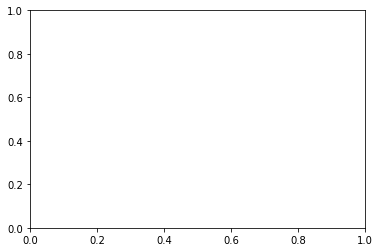

In [70]:
DCGAN()

In [11]:
#noise = np.random.normal(loc=0 , scale=0.2 , size=(3, 2, 1, 1))
#print(noise)

[[[[ 0.13897881]]

  [[ 0.11966697]]]


 [[[-0.47545968]]

  [[ 0.2212227 ]]]


 [[[ 0.19881932]]

  [[-0.03660763]]]]


In [22]:
#########################
# This cell shows that we don't need to reshape our initial noise
# We can just specify all dims when creating the noise
#########################
noise = np.random.uniform(low=-1.0, high=1.0, size=(2, 3))
print(noise.shape)
y = np.expand_dims(noise, axis=2)
print(y.shape)
z = np.expand_dims(y, axis=3)
print(z.shape)
print(z)
print()
print(np.random.uniform(low=-1.0, high=1.0, size=(2, 3,1,1)))

(2, 3)
(2, 3, 1)
(2, 3, 1, 1)
[[[[-0.15162636]]

  [[-0.31837529]]

  [[-0.26284121]]]


 [[[-0.37285482]]

  [[-0.00284007]]

  [[ 0.22228344]]]]

[[[[-0.29609413]]

  [[-0.24723667]]

  [[ 0.30993767]]]


 [[[-0.98739054]]

  [[-0.47790569]]

  [[-0.94762318]]]]


In [12]:
# Try different values and see the output dimensions of each layer
# Experiment and find suitable values

##########################
# GENERATOR
##########################
reset_graph()

batch_size = 128

model = tf.keras.Sequential()
noise = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 1, 1, 100))

model.add(layers.Conv2DTranspose(input_shape=(1, 1, 100), filters=128, kernel_size=(7,7), strides=(1,1), padding="valid",
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.ReLU())

model.add(layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid",
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.ReLU())

model.add(layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), padding="valid",
                                 kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                 activation='tanh'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         627328    
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         257       
Total para

In [26]:
# Try different values and see the output dimensions of each layer
# Experiment and find suitable values

##########################
# DISCRIMINATOR
##########################


model = tf.keras.Sequential()
        
# Input is batchx28x28x1
model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                        kernel_size=(2,2), strides=(2,2), padding="valid",
                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.LeakyReLU(alpha=0.2))

# Input is batchx14x14x???
model.add(layers.Conv2D(filters=128, kernel_size=(2,2), 
                        strides=(2,2), padding="valid",
                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(filters=256, kernel_size=(6,6), 
                        strides=(2,2), padding="valid",
                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
model.add(layers.BatchNormalization(scale=False, center=False))
model.add(layers.LeakyReLU(alpha=0.2))

# Input is batchx7x7x???
model.add(layers.Flatten()) # Output is batchx7*7*128
model.add(layers.Dense(units=256, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                       activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)         32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 128)         256       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 1, 256)         1179904   
_________________________________________________________________
batch_normalization_19 (Batc (None, 1, 1, 256)         512       
__________

In [29]:
print(np.random.uniform(low=0, high=0.3, size=(100)).shape)

(100,)


In [32]:
print(train_imgs.shape)

(60000, 28, 28)


In [36]:
batch = 3
batch_size = 128
imgs = train_imgs[batch*batch_size:batch*batch_size+batch_size, :, :] # Extract a batch of training images
print(imgs.shape)

(128, 28, 28)


NameError: name '_buildGenerator' is not defined

In [45]:
def _buildGenerator():
#model = tf.keras.Input() # Sequential or Functional API?
    # In the blog post they use a reshape, is that neccessary? Investigate
    #noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, 1, 1, 100))
    model = tf.keras.Sequential()

    # Read the link below to understand output shapes of Conv2DTranspose
    # https://stackoverflow.com/questions/50683039/conv2d-transpose-output-shape-using-formula
    # Output shape: (batch, new_rows, new_cols, filters)
    model.add(layers.Conv2DTranspose(input_shape=(1, 1, 100), filters=128, kernel_size=(7,7), 
                                     strides=(1,1), padding="valid",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(2,2), padding="valid",
                                     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                                     activation='tanh'))

    #model.summary()

    # Inspired by https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
    #noise = tf.keras.Input(shape=(1, 1, 100))
    #image = model(noise)

    #return Model(noise, image)
    return model

def _buildDiscriminator():
    """
    Constructs the discriminator part of the DCGAN
    """
    ##########
    # Layers #
    ##########

    model = tf.keras.Sequential()

    # Input is batchx28x28x1
    model.add(layers.Conv2D(input_shape=(28, 28, 1), filters=64,
                            kernel_size=(2,2), strides=(2,2), padding="valid",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Input is batchx14x14x???
    model.add(layers.Conv2D(filters=128, kernel_size=(2,2), 
                            strides=(2,2), padding="valid",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(filters=256, kernel_size=(6,6), 
                            strides=(2,2), padding="valid",
                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization(scale=False, center=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Input is batchx7x7x???
    model.add(layers.Flatten()) # Output is batchx7*7*128
    model.add(layers.Dense(units=1, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                           activation=tf.nn.sigmoid))

    #model.summary()
    return model
    
def build():
    model = tf.keras.Sequential()
    g = _buildGenerator()
    d = _buildDiscriminator()
    d.trainable = False
    model.add(g)
    model.add(d)
    model.summary()
    
build()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 28, 28, 1)         660801    
_________________________________________________________________
sequential_29 (Sequential)   (None, 1)                 1214145   
Total params: 1,874,946
Trainable params: 660,417
Non-trainable params: 1,214,529
_________________________________________________________________


In [64]:
print(train_imgs.shape[0])

60000
